# The Impact of Neighbourhood Composition on Resident COVID-19 Infection Rates in Toronto

## Preliminary Things

### Import Necessary Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

### Define Functions:

In [2]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    """
    Given neighbourhood names, latitudes, longitudes, and a radius defining
    the neighbourhood from its geographical centre, get the venues near that neighbourhood."""
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


def return_most_common_venues(row, num_top_venues):
    """
    Return most common venues from neighbourhood."""
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

## Data Acquisition and Cleaning

### Neighbourhood/COVID-19 Data:

In [3]:
# Geographical coordinates are taken from Google and
# added to COVID rates which are taken from Toronto Public Health.
html_neighbourhoods = 'https://raw.githubusercontent.com/LiamBrowne/Coursera_Capstone/0901b88731895608fb3fd32ccaac29ca0ffdbe0f/covid_rates.csv'
neighbourhoods = pd.read_csv(html_neighbourhoods)
neighbourhoods.drop(["Neighbourhood ID", "Case Count"], axis=1, inplace=True)

### Venue Data:

In [4]:
# Fouraquare Credentials and Version:
CLIENT_ID = 'GJAFN4V5WYS5VV3HSOD5OFKRMWP1TD5MOULNEIQHYTIIWIBR'
CLIENT_SECRET = 'KUI3QBF3KDAW33UMVKMVCTVMZ2KV5EH511D00FBUUCZELUEC'
VERSION = '20180605'
limit = 100
radius = 500

# Get the venues.
toronto_venues = getNearbyVenues(names=neighbourhoods['Neighbourhood Name'],
                                 latitudes=neighbourhoods['Latitude'],
                                 longitudes=neighbourhoods['Longitude'])

Eglinton East
Don Valley Village
Lansing-Westgate
Edenbridge-Humber Valley
Flemingdon Park
Danforth East York
Agincourt North
Mount Pleasant East
Woburn
Forest Hill North
Rockcliffe-Smythe
Milliken
Thorncliffe Park
Willowridge-Martingrove-Richview
Woodbine-Lumsden
Markland Wood
Princess-Rosethorn
Lambton Baby Point
Kingsway South
Centennial Scarborough
Church-Yonge Corridor
Downsview-Roding-CFB
Taylor-Massey
Kennedy Park
Yonge-Eglinton
Clairlea-Birchmount
Junction Area
Mount Dennis
Englemount-Lawrence
Waterfront Communities-The Island
South Riverdale
North St. James Town
Humewood-Cedarvale
Dovercourt-Wallace Emerson-Junction
Banbury-Don Mills
Yonge-St.Clair
Mount Pleasant West
Henry Farm
Humber Heights-Westmount
Runnymede-Bloor West Village
South Parkdale
Guildwood
Tam O'Shanter-Sullivan
Newtonbrook West
Little Portugal
Bayview Woods-Steeles
Niagara
Islington-City Centre West
Cliffcrest
L'Amoreaux
Birchcliffe-Cliffside
Trinity-Bellwoods
Eringate-Centennial-West Deane
Elms-Old Rexdale
W

## Data Analysis

### Most Common Venue Types:

In [5]:
# Get the top ten most common types of venues in each neighbourhood.
num_top_venues = 10
# One hot encoding.
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# Add neighborhood column back to dataframe.
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood'] # Create columns according to number of top venues.
for ind in np.arange(num_top_venues):
    try:
        columns.append(f"{ind+1}{indicators[ind]} Most Common Venue")
    except:
        columns.append(f"{ind+1}th Most Common Venue")

# Create a new dataframe.
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :],
                                                                          num_top_venues)

### Finding Optimal K for K-Means Clustering:

In [6]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

#### Define Function to Find Optimal K Using Gap Statistic:

In [7]:
# This function is taken from Miles Granger (https://anaconda.org/milesgranger/gap-statistic/notebook)
def optimalK(data, nrefs=10, maxClusters=30):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [8]:
k, gapdf = optimalK(toronto_grouped_clustering, nrefs=10, maxClusters=30)
print('Optimal k is: ', k)

Optimal k is:  28


#### Plot Gap Value for Inceasing Values of K:

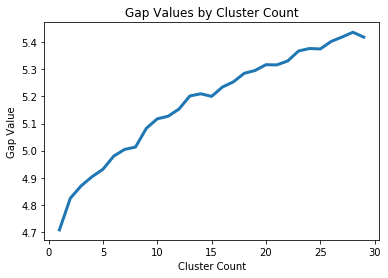

In [9]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

After trying different values for the maximum K, I realized that the algorithm was always selecting one less than the specified maximum number of Ks. This is because the gap value is increasing without a sufficiently large drop. As such, I will now employ the so-called elbow method to examine the distortion of various K values.

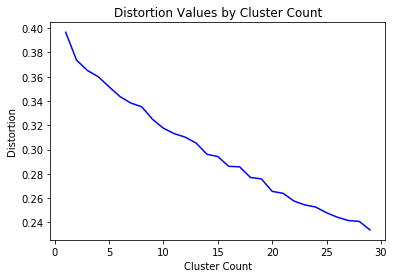

In [10]:
# The following code is taken from Billy Bonaros (https://predictivehacks.com/k-means-elbow-method-code-for-python/)
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'),
                                  axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'b')
plt.xlabel('Cluster Count')
plt.ylabel('Distortion')
plt.title('Distortion Values by Cluster Count')
plt.show()

After repeating this process for various maximum values for K, it becomes apparent that the distortion is decreasing without any clear inflection (the so-called "elbow"). As such, I will abandon the gap and elbow methods in favour of following suit with the previous exercise and choose **k=5**.

### Cluster Neighbourhoods by Venue Type:

In [11]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

### Merge Clusters With Top Ten Venues:

In [12]:
# Add clustering labels.
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = neighbourhoods
# Merge toronto_grouped with neighbourhoods to add latitude & longitude for each neighbourhood.
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood Name')
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype('int32')

### Visualize Clusters:

In [13]:
# Get geographical coordinates of Toronto.
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Create map.
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to map.
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'],
                                  toronto_merged['Longitude'],
                                  toronto_merged['Neighbourhood Name'],
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Naming the Clusters:

In [14]:
toronto_merged.head()

,Neighbourhood Name,"Rate per 100,000 people",Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Eglinton East,430.277485,43.7371,-79.2462,1,Pharmacy,Sandwich Place,Japanese Restaurant,Auto Garage,Beer Store,Liquor Store,Grocery Store,Bus Station,Fast Food Restaurant,Farmers Market
1,Don Valley Village,255.073750,43.7874,-79.3530,0,Bakery,Park,Fried Chicken Joint,Grocery Store,Caribbean Restaurant,Fruit & Vegetable Store,Sandwich Place,Beer Store,Gas Station,Pizza Place
2,Lansing-Westgate,222.717149,43.7590,-79.4226,2,Spa,Women's Store,Dog Run,Fish Market,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant
3,Edenbridge-Humber Valley,656.581912,43.6671,-79.5280,4,Park,Baseball Field,Skating Rink,Women's Store,Event Space,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Falafel Restaurant,Donut Shop
4,Flemingdon Park,606.392194,43.7184,-79.3314,1,Gym,Fast Food Restaurant,Café,Coffee Shop,Grocery Store,Gym / Fitness Center,Women's Store,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant


In [15]:
# Find most popular item in "1st Most Common Venue" column for each cluster.
common_labels = toronto_merged.groupby('Cluster Labels')['1st Most Common Venue'].agg(lambda x:x.value_counts().index[0])
print(common_labels)

Cluster Labels
0                        Bakery
1                   Coffee Shop
2             Convenience Store
3    Construction & Landscaping
4                          Park
Name: 1st Most Common Venue, dtype: object


I'll now use the name of the most common item in "1st Most Common Venue" columns to name the clusters.

In [22]:
# Rename cluster labels.
new_cluster_names = {
    0: 'Bakery', 
    1: 'Coffee Shop',
    2: 'Convenience Store',
    3: 'Construction & Landscaping',
    4: 'Park'
}
toronto_merged.rename(columns={'Rate per 100,000 people': 'Rate Per 100,000 People', 'Cluster Labels': 'Neighbourhood Type'}, inplace=True)
toronto_merged['Neighbourhood Type'].replace(new_cluster_names, inplace=True)

### Violin Plots:

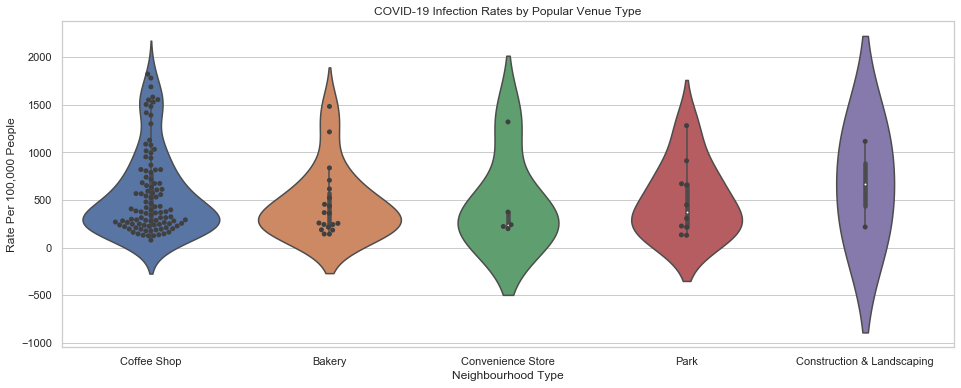

In [31]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
ax = sns.violinplot(x='Neighbourhood Type', y='Rate Per 100,000 People', data=toronto_merged)
ax.set_title('COVID-19 Infection Rates by Popular Venue Type')
sns.swarmplot(x='Neighbourhood Type', y='Rate Per 100,000 People', data=toronto_merged, color='0.25')
plt.show()